In [2]:
import torch
from torch.utils.data import Dataset
from torch import nn
import glob
import numpy as np
import torch.nn.functional as F
import os
from PIL import Image, ImageDraw
from torchvision import transforms as T
import cv2
from depth_utils import load_colmap_depth
from ray_utils import *
from matplotlib import pyplot as plt

In [2]:
def normalize(v):
    """Normalize a vector."""
    return v/np.linalg.norm(v)

def average_poses(poses):
    """
    Calculate the average pose, which is then used to center all poses
    using @center_poses. Its computation is as follows:
    1. Compute the center: the average of pose centers.
    2. Compute the z axis: the normalized average z axis.
    3. Compute axis y': the average y axis.
    4. Compute x' = y' cross product z, then normalize it as the x axis.
    5. Compute the y axis: z cross product x.
    
    Note that at step 3, we cannot directly use y' as y axis since it's
    not necessarily orthogonal to z axis. We need to pass from x to y.

    Inputs:
        poses: (N_images, 3, 4)

    Outputs:
        pose_avg: (3, 4) the average pose
    """
    # 1. Compute the center
    center = poses[..., 3].mean(0) # (3)

    # 2. Compute the z axis
    z = normalize(poses[..., 2].mean(0)) # (3)

    # 3. Compute axis y' (no need to normalize as it's not the final output)
    y_ = poses[..., 1].mean(0) # (3)

    # 4. Compute the x axis
    x = normalize(np.cross(y_, z)) # (3)

    # 5. Compute the y axis (as z and x are normalized, y is already of norm 1)
    y = np.cross(z, x) # (3)

    pose_avg = np.stack([x, y, z, center], 1) # (3, 4)

    return pose_avg

def center_poses(poses):
    """
    Center the poses so that we can use NDC.
    See https://github.com/bmild/nerf/issues/34

    Inputs:
        poses: (N_images, 3, 4)

    Outputs:
        poses_centered: (N_images, 3, 4) the centered poses
        pose_avg: (3, 4) the average pose
    """

    pose_avg = average_poses(poses) # (3, 4)
    pose_avg_homo = np.eye(4)
    pose_avg_homo[:3] = pose_avg # convert to homogeneous coordinate for faster computation
                                 # by simply adding 0, 0, 0, 1 as the last row
    last_row = np.tile(np.array([0, 0, 0, 1]), (len(poses), 1, 1)) # (N_images, 1, 4)
    poses_homo = \
        np.concatenate([poses, last_row], 1) # (N_images, 4, 4) homogeneous coordinate

    poses_centered = np.linalg.inv(pose_avg_homo) @ poses_homo # (N_images, 4, 4)
    poses_centered = poses_centered[:, :3] # (N_images, 3, 4)

    return poses_centered, pose_avg

B_CODING_VARIANTS = 3
self_transform = T.ToTensor()

In [7]:
a=Image.open('../data/nerf_llff_data/trex/images_4/DJI_20200223_163551_210.png')
b=Image.open('../data/nerf_llff_data/trex/images_4/DJI_20200223_163551_210.png').convert('RGB')

In [4]:
trainlist=['DJI_20200223_163548_810','DJI_20200223_163551_210','DJI_20200223_163551_990',\
        'DJI_20200223_163553_010','DJI_20200223_163553_790','DJI_20200223_163554_630']
temp = []
for name in trainlist:
    temp+=[self_image_paths.index('../data/nerf_llff_data/trex/images_4/'+name+'.png')]
print(temp)

NameError: name 'self_image_paths' is not defined

In [18]:
def homo_w(src_feat, proj_mat, depth_values, src_grid=None, pad=0):
    """
    src_feat: (C, H, W)
    proj_mat: (3, 4) equal to "src_proj @ ref_proj_inv"
    depth_values: (H, W)
    out: (C, H, W)
    """

    if src_grid==None:
        C, H, W = src_feat.shape
        device = src_feat.device
        if pad>0:
            H_pad, W_pad = H + pad*2, W + pad*2
        else:
            H_pad, W_pad = H, W

        # depth_values = depth_values[...,None,None].repeat(1, 1, H_pad, W_pad)
        # D = depth_values.shape[1]

        R = proj_mat[:, :3]  # (3, 3)
        T = proj_mat[:, 3:]  # (3, 1)
        # create grid from the ref frame
        ref_grid = create_meshgrid(H_pad, W_pad, normalized_coordinates=False, device=device)  # (1, H, W, 2)
        if pad>0:
            ref_grid -= pad

        ref_grid = ref_grid.permute(0, 3, 1, 2)  # (1, 2, H, W)
        ref_grid = ref_grid.reshape(1, 2, W_pad * H_pad)  # (1, 2, H*W)
        ref_grid = torch.cat((ref_grid, torch.ones_like(ref_grid[:, :1])), 1)  # (1, 3, H*W)
        # ref_grid_d = ref_grid.repeat(1, D)  # (3, D*H*W)
        
        src_grid_d = R @ ref_grid + T / depth_values.view(1, W_pad * H_pad)
        del ref_grid, proj_mat, R, T, depth_values  # release (GPU) memory

        src_grid = src_grid_d[0,:2] / src_grid_d[0,2:]  # divide by depth (., H*W)
        del src_grid_d
        src_grid[0] = src_grid[0] / ((W - 1) / 2) - 1  # scale to -1~1
        src_grid[1] = src_grid[1] / ((H - 1) / 2) - 1  # scale to -1~1
        src_grid = src_grid.T  # (B, H*W, 2)
        src_grid = src_grid.view(1, W_pad,H_pad, 2)

    B, W_pad, H_pad = src_grid.shape[:3]
    warped_src_feat = F.grid_sample(src_feat.unsqueeze(0), src_grid,
                                    mode='bilinear', padding_mode='zeros',
                                    align_corners=True)  # (C, H*W)
    warped_src_feat = warped_src_feat.view(C,H_pad,W_pad)
    # src_grid = src_grid.view(B, 1, H_pad, W_pad, 2)
    return warped_src_feat, src_grid

In [19]:
self_img_wh = (504,378)
root_dir='../data/nerf_llff_data/trex/'
# root_dir='../../trex/'

poses_bounds = np.load(os.path.join(root_dir,
                                    'poses_bounds.npy')) # (N_images, 17)
                                    
self_image_paths = sorted(glob.glob(os.path.join(root_dir, 'images_4/*')))
                # load full resolution image then resize
poses = poses_bounds[:, :15].reshape(-1, 3, 5) # (N_images, 3, 5)
self_bounds = poses_bounds[:, -2:] # (N_images, 2)

# Step 1: rescale focal length according to training resolution
H, W, self_focal = poses[0, :, -1]
self_focal *= self_img_wh[0]/W

# print('depth shape:',self_depth_list.shape)

self_K = np.eye(3)
self_K[0, 0] = self_K[1, 1] = self_focal
self_K[0, 2] = self_img_wh[0]/2
self_K[1, 2] = self_img_wh[1]/2 # intrinsic!

poses = np.concatenate([poses[..., 1:2], -poses[..., :1], poses[..., 2:4]], -1)
        # (N_images, 3, 4) exclude H, W, focal
self_poses, self_pose_avg = center_poses(poses)
distances_from_center = np.linalg.norm(self_poses[..., 3], axis=1)
val_idx = np.argmin(distances_from_center) # choose val image as the closest to
                                            # center image

near_original = self_bounds.min()
scale_factor = near_original*0.75 # 0.75 is the default parameter
                                    # the nearest depth is at 1/0.75=1.33
self_bounds /= scale_factor
self_poses[..., 3] /= scale_factor

near = self_bounds.min()
far = self_bounds.max()
self_depth_list = (torch.from_numpy(load_colmap_depth(root_dir,self_img_wh,bd_factor=None,mode='blend',use_raw=True)).float()).unsqueeze(1)
# self_depth_list = 1/(1-self_depth_list)
# self_depth_list = self_depth_list*(far-near)+near
# self_poses[:,:3,3] = self_poses[:,:3,3]

# ray directions for all pixels, same for all images (same H, W, focal)
# self_directions = \
#     get_ray_directions(self_img_wh[1], self_img_wh[0], self_K) # (H, W, 3)
self_K = torch.Tensor(self_K)
# self_train_list = [2,4,6,8,10, 12,14,16,18,22,24,26,28,30,32]
self_train_list = np.array([21])

for i, image_path in enumerate(self_image_paths):
    if i not in self_train_list:
        continue
    c2w = torch.FloatTensor(poses[i])
    img_ori = Image.open(image_path).convert('RGB')
    img = img_ori
    img = img.resize(self_img_wh, Image.LANCZOS)
    # positions = self_poses[:,:3,3]
    # # dis = np.sum(np.abs(positions-self_poses[i,:3,3:].T),axis=-1)
    # dis = np.sum((positions-self_poses[i,:3,3].T)**2,axis=-1)
    cr_rotation = self_poses[i,:3,:3].T
    rotation_distance = []
    for rotation in self_poses[:,:3,:3]:
        rot = rotation @ cr_rotation
        rotation_distance.append(-np.trace(rot))
    positions = self_poses[:,:3,3]
    dis = np.sum((positions-self_poses[i,:3,3].T)**2,axis=-1)
    pair_idx = np.argsort(dis+100*np.array(rotation_distance))
    # pair_idx = np.array([0,-1,1,-2,2])+i
    # print(pair_idx)
    # for ind,ref_idx in enumerate(pair_idx):
    # ref_translation = torch.zeros(3)
    for ind in [0,1,2,3,4]:
        ref_idx = pair_idx[ind]
        tempc2w=torch.eye(4)
        tempc2w[:3]=torch.FloatTensor(poses[ref_idx])
        # print(tempc2w)
        w2c = torch.inverse(tempc2w)
        # print(w2c)
        proj_mat_l = torch.eye(4)
        proj_mat_l[:3]=self_K @ w2c[:3]
        # print(proj_mat_l)
        if (ind == 0):
            ref_proj_inv = torch.inverse(proj_mat_l)
            ref_translation = tempc2w[:3,3]
            proj_mat = torch.eye(4) # reference image
        else:
            proj_mat = proj_mat_l @ ref_proj_inv
            # proj_mat[:3,3] = -tempc2w[:3,3]+ref_translation
        print(proj_mat)
        ref_img = Image.open(self_image_paths[ref_idx]).convert('RGB')
        filename = self_image_paths[ref_idx].split('/')[-1][:-4]
        ref_img = ref_img.resize(self_img_wh, Image.LANCZOS)
        ref_img.save('./test/'+str(ind)+'_'+filename+'.jpg',quality=100)
        inp = self_transform(ref_img)
        warped_src_feat, _ = homo_w(inp,proj_mat[:3], self_depth_list[i])
        warped_src_feat = np.uint8(255*np.array(warped_src_feat.permute(1,2,0)))
        plt.imsave('./test/'+str(ind)+'_'+filename+'W.jpg',warped_src_feat,pil_kwargs={'quality':100})

Mean Projection Error: 1.2315129676427423
Loaded image data (756, 1008, 3, 55) [ 756.         1008.          832.46748929]
near/far: 13.150153255462646 128.972412109375
tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])
tensor([[ 1.0051e+00, -4.6396e-03, -3.9337e+00,  2.8727e+02],
        [ 3.0511e-03,  9.9583e-01,  3.7880e+00, -5.8902e+02],
        [ 2.0288e-05, -2.1824e-05,  9.9894e-01,  5.3148e-01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]])
tensor([[ 9.9623e-01, -7.4049e-03,  4.9020e+00,  3.8830e+02],
        [-7.2561e-03,  9.9100e-01,  1.1548e+01, -3.2982e+02],
        [-1.4834e-05, -4.6575e-05,  1.0123e+00,  2.8688e-01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]])
tensor([[ 1.0177e+00, -8.6017e-03, -1.5404e+01, -4.9637e+02],
        [ 2.2540e-02,  1.0002e+00, -6.1629e+00,  5.2424e+01],
        [ 7.1983e-05,  1.4073e-06,  9.8115e-01,  6.4052e-02],
        [ 0.0000e+00,  0.0000e+00,  0.0000

In [16]:
self_poses[21]

array([[ 0.99888629,  0.01505651,  0.04471563,  0.66672541],
       [-0.01624467,  0.99952136,  0.02632792, -0.0763021 ],
       [-0.04429782, -0.02702499,  0.99865277, -0.03382732]])

In [5]:
import imshowpair
ref_img = Image.open(self_image_paths[53]).convert('RGB')
ref_img = ref_img.resize(self_img_wh, Image.LANCZOS)
inp = self_transform(ref_img)
warped_src_feat, _ = homo_warp(inp,proj_mat[:3], self_depth_list[53])
warped_src_feat = np.uint8(255*np.array(warped_src_feat.permute(1,2,0)))
imshowpair(warped_src_feat,inp.permute(1,2,0))

TypeError: 'module' object is not callable

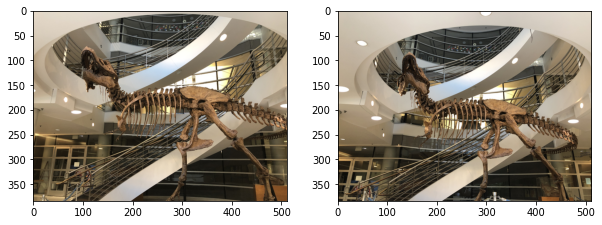

In [5]:
plt.subplots(figsize=(10,6))
plt.subplot(121);plt.imshow(img)
plt.subplot(122);plt.imshow(inp.permute(1,2,0))

In [5]:
warped_src_feat.shape

torch.Size([3, 384, 512])

In [6]:
inp.shape

torch.Size([3, 384, 512])

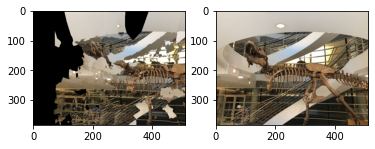

In [7]:
plt.subplot(121)
plt.imshow(warped_src_feat.permute(1,2,0))
plt.subplot(122)
plt.imshow(inp.permute(1,2,0))

In [17]:
proj_mat

tensor([[ 1.0147e+00, -4.4613e-03, -1.3448e+01, -3.1935e+01],
        [ 1.5933e-02,  1.0002e+00, -4.3854e+00,  5.3323e-01],
        [ 5.8563e-05,  9.3105e-07,  9.8452e-01,  8.3393e-03],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]])

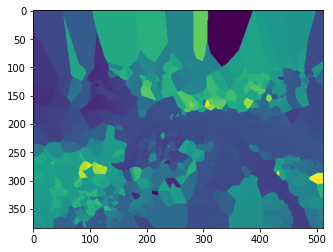

In [36]:
plt.imshow(self_depth_list[3][0])

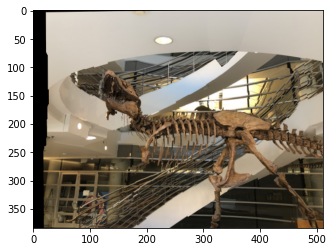

In [43]:
warped_src_feat, _ = homo_warp(inp,proj_mat[:3], (self_depth_list[3])*15)
plt.imshow(warped_src_feat.permute(1,2,0))